In [1]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import odeint
from scipy.optimize import minimize
print(tf.__version__)

2.10.0


In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)  # Add this line for TensorFlow
    # torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

set_random_seed(7777)

In [3]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units=20, activation='tanh', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(units=20, activation='tanh', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(units=20, activation='tanh', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(units=2, kernel_initializer=tf.keras.initializers.HeNormal())
])

NN.summary()

# optim = tf.keras.optimizers.Adam(learning_rate = 0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 922
Trainable params: 922
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Masses
m1 = 1.0
m2 = 1.0
# Spring constants
k1 = 5.0
k2 = 2.0
# Natural lengths
L1 = 0.5
L2 = 0.5

# Initial conditions
# d1_0 and d2_0 are the initial displacements; v1_0 and v2_0 are the initial velocities
d1_0 = 0.5
d2_0 = 3.25

v1_0 = 0.0
v2_0 = 0.0

b1 = 0
b2 = 0

# maximum time to simulate
t_max = 5

In [5]:
def pde_system(t, net):
    t = tf.constant(t, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        net_output = net(t)
        x1, x2 = tf.split(net_output, 2, axis=1)

    # 컨텍스트 외부에서 첫 번째 미분 계산
    with tape:
        x1_t = tape.gradient(x1, t)
        x2_t = tape.gradient(x2, t)

    # 지속적인 테이프 사용으로 여러 gradient() 호출 가능
    x1_tt = tape.gradient(x1_t, t)
    x2_tt = tape.gradient(x2_t, t)
    
    # 사용 완료 후 테이프 제거
    del tape

    pde1_loss = m1 * x1_tt + k1 * (x1 - L1) - k2 * (x2 - x1 - L2)
    pde2_loss = m2 * x2_tt + k2 * (x2 - x1 - L2)

    # 초기 조건 손실 수정
    IC_loss = tf.reduce_mean(tf.square(net_output[0, :] - tf.constant([d1_0, d2_0], dtype=tf.float32))) + \
          tf.reduce_mean(tf.square(tf.stack([x1_t[0], x2_t[0]]) - tf.constant([v1_0, v2_0], dtype=tf.float32)))

    total_loss = tf.reduce_mean(tf.square(pde1_loss) + tf.square(pde2_loss)) + IC_loss

    return total_loss

In [6]:
#  Adam 최적화기
initial_learning_rate = 0.001
learning_rate = initial_learning_rate
learning_rate_decay_factor = 0.5  # 학습률을 반으로 줄이기
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Adam 최적화기 초기화

# 평탄화된 가중치를 모델의 원래 가중치 형태로 변환하는 과정을 포함한 loss_and_grads 함수
def loss_and_grads(flattened_variables):
    with tf.GradientTape() as tape:
        # 평탄화된 변수를 원래 형태로 변환
        new_weights = unflatten_variables(flattened_variables, NN.trainable_variables)
        NN.set_weights(new_weights)  # 변환된 가중치를 모델에 설정
        loss = pde_system(train_t, NN)  # 손실 계산
    grads = tape.gradient(loss, NN.trainable_variables)  # 그래디언트 계산
    # 그래디언트를 다시 평탄화하여 반환
    grads_flattened = np.concatenate([g.numpy().flatten() for g in grads])
    return loss.numpy().astype('float64'), grads_flattened.astype('float64')

In [7]:
# 모델 변수를 평탄화하는 함수
def flatten_variables(variables):
    return np.concatenate([v.numpy().flatten() for v in variables])

# 평탄화된 변수를 원래 모양의 변수로 변환하는 함수
def unflatten_variables(flattened, variables):
    new_vars = []
    idx = 0
    for var in variables:
        var_size = np.prod(var.shape)
        new_var = flattened[idx: idx + var_size].reshape(var.shape)
        new_vars.append(new_var)
        idx += var_size
    return new_vars

In [8]:
# Data
train_t = np.linspace(0, t_max, num=100).reshape(-1, 1)

# 학습률 조정을 위한 기준 설정 (여기서는 1000번 반복마다 손실 개선 확인)
check_interval = 1000
improvement_threshold = 0.01  # 개선되었다고 판단할 최소 손실 감소율

train_loss_record = []
min_loss = np.inf
loss_not_improved_count = 0

# 훈련 루프
for itr in range(10000): # 10000
    
    if itr < 3000: # 5000
        # print("Adam")
        # Adam 최적화기 사용
        with tf.GradientTape() as tape:
            train_loss = pde_system(train_t, NN)
        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        adam_optimizer.apply_gradients(zip(grad_w, NN.trainable_variables))
        train_loss_value = train_loss.numpy()
        train_loss_record.append(train_loss_value)
        
        # 학습률 조정 로직
        if train_loss_value < min_loss * (1 - improvement_threshold):
            min_loss = train_loss_value
            loss_not_improved_count = 0
        else:
            loss_not_improved_count += 1
        
        # 지정된 간격마다 손실 개선 여부 확인 후 학습률 조정
        if (itr + 1) % check_interval == 0 and loss_not_improved_count >= check_interval:
            learning_rate *= learning_rate_decay_factor
            adam_optimizer.learning_rate.assign(learning_rate)
            print(f"Reducing learning rate to {learning_rate:.6f} at iteration {itr+1}")
            loss_not_improved_count = 0  # 카운터 초기화
            
    else:
        # print("L-BFGS")
        # L-BFGS 최적화기 사용
        if itr == 3000:  # L-BFGS 최적화 시작
            variables = flatten_variables(NN.trainable_variables)
            result = minimize(fun=loss_and_grads, x0=variables, method='L-BFGS-B', jac=True, options={'maxiter': 7000})
            optimized_vars = unflatten_variables(result.x, NN.trainable_variables)
            for var, new_val in zip(NN.trainable_variables, optimized_vars):
                var.assign(new_val)
            
            # L-BFGS 최적화 이후 손실 평가
            post_optimization_loss = pde_system(train_t, NN).numpy()
            train_loss_record.append(post_optimization_loss)
            print(f"Post-optimization Loss: {post_optimization_loss:.4f}")
            # 중복된 손실 기록 삭제
            break

    train_loss_record.append(train_loss.numpy())
    
    if (itr+1) % 100 == 0: # 100
        print(f"Iteration {itr+1}, Loss: {train_loss.numpy():.4f}")

Iteration 100, Loss: 3.6543
Iteration 200, Loss: 1.8128
Iteration 300, Loss: 1.1653
Iteration 400, Loss: 0.8839
Iteration 500, Loss: 0.8186
Iteration 600, Loss: 0.7961
Iteration 700, Loss: 0.7775
Iteration 800, Loss: 0.7599
Iteration 900, Loss: 0.7428
Iteration 1000, Loss: 0.7257
Iteration 1100, Loss: 0.7081
Iteration 1200, Loss: 0.6900
Iteration 1300, Loss: 0.6714
Iteration 1400, Loss: 0.6509
Iteration 1500, Loss: 0.6273
Iteration 1600, Loss: 0.6022
Iteration 1700, Loss: 0.5767
Iteration 1800, Loss: 0.5499
Iteration 1900, Loss: 0.5213
Iteration 2000, Loss: 0.4904
Iteration 2100, Loss: 0.4566
Iteration 2200, Loss: 0.4196
Iteration 2300, Loss: 0.3798
Iteration 2400, Loss: 0.3396
Iteration 2500, Loss: 0.3013
Iteration 2600, Loss: 0.2665
Iteration 2700, Loss: 0.2374
Iteration 2800, Loss: 0.2166
Iteration 2900, Loss: 0.2049
Iteration 3000, Loss: 0.1992
Post-optimization Loss: 0.0006


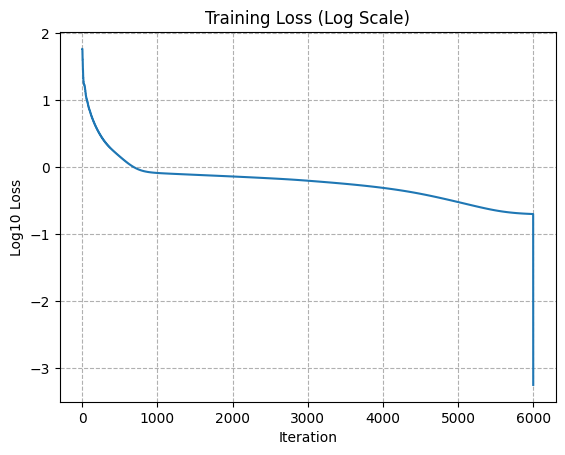

In [9]:
# 밑이 10인 로그 스케일로 손실 값 변환
log_train_loss_record = np.log10(train_loss_record)

# 그래프 생성
plt.figure() # figsize=(10, 6)
plt.plot(log_train_loss_record)
plt.xlabel('Iteration')
plt.ylabel('Log10 Loss')
plt.title('Training Loss (Log Scale)')
plt.grid(True, which="both", ls="--")
plt.show()

In [10]:
# 테스트 데이터
test_t = np.linspace(0, t_max, 100).reshape(-1, 1)

# 결과 확인
pred_u = NN.predict(test_t)
print(np.shape(pred_u))

4/4 [==============================] - 0s 679us/step
(100, 2)


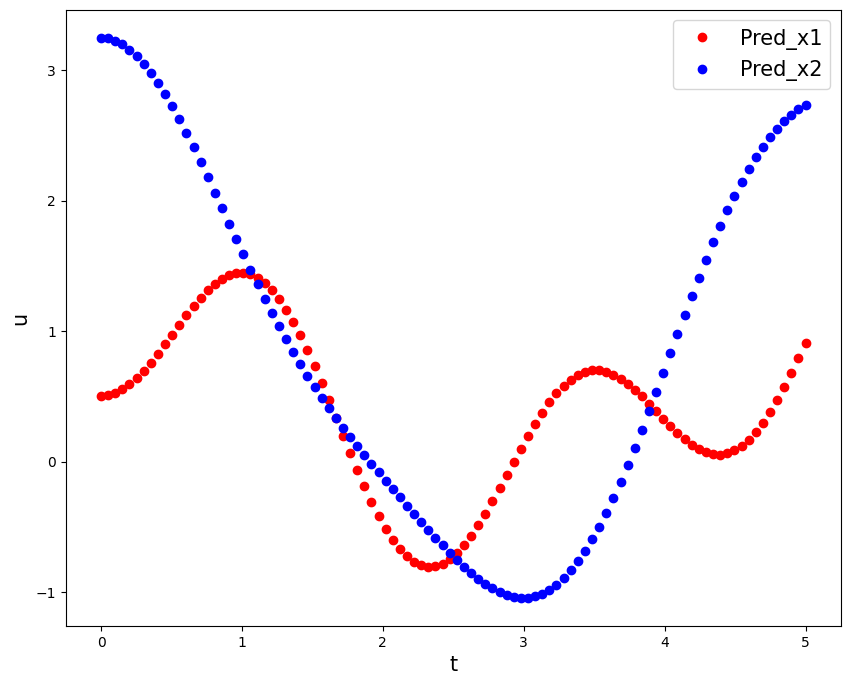

In [11]:
plt.figure(figsize = (10,8))
plt.plot(test_t, pred_u[:,0], 'or',label = 'Pred_x1')
plt.plot(test_t, pred_u[:,1], 'ob',label = 'Pred_x2')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [12]:
def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.
 
    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, y1, x2, y2 = w
    m1, m2, k1, k2, L1, L2, b1, b2 = p
 
    # Create f = (x1',y1',x2',y2'):
    f = [y1,
         (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1,
         y2,
         (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2]
    return f

# Parameter values -> ICs
m1, m2, k1, k2, L1, L2, b1, b2 = 1.0, 1.0, 5.0, 2.0, 0.5, 0.5, 0, 0
p = [m1, m2, k1, k2, L1, L2, b1, b2]

d1_0, d2_0, v1_0, v2_0 = 0.5, 3.25, 0.0, 0.0
w0 = [d1_0, v1_0, d2_0, v2_0]

# ODE solver 
abserr = 1.0e-8
relerr = 1.0e-6
t_max = 5
numpoints = 250
t = np.linspace(0, t_max, numpoints)
wsol = odeint(vectorfield, w0, t, args=(p,), atol=abserr, rtol=relerr)

# NN
t_reshaped = t.reshape(-1, 1)  # 모델에 맞게 차원 조정
predictions = NN.predict(t_reshaped)  # NN은 앞서 정의한 TensorFlow 모델
usol1 = predictions[:, 0]
usol2 = predictions[:, 1]

8/8 [==============================] - 0s 712us/step


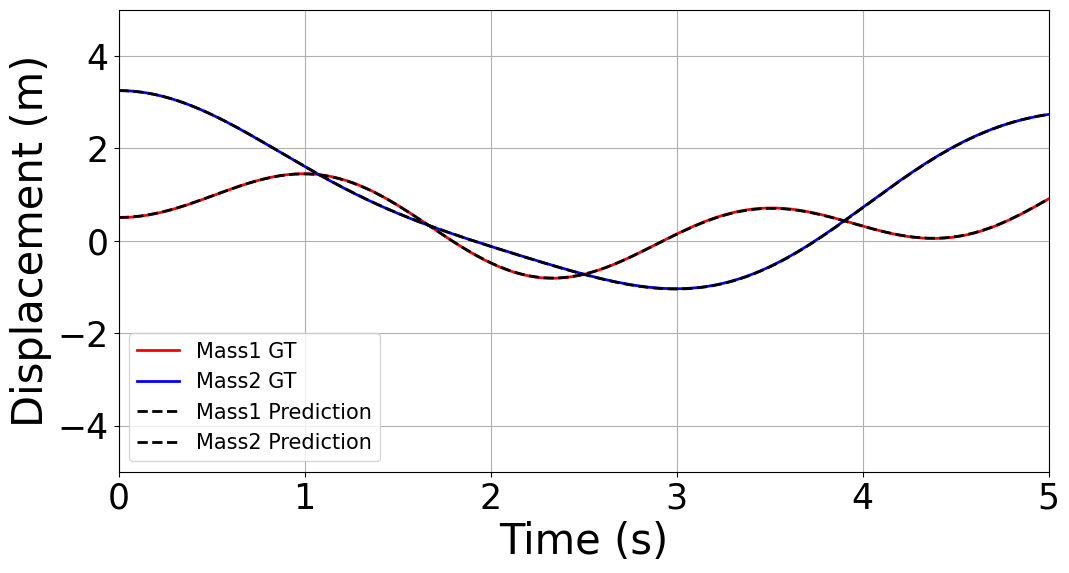

In [17]:
# 결과 그래프
plt.figure(figsize=(12, 6))
plt.plot(t, wsol[:, 0], 'r', label='Mass1 GT', lw=2)
plt.plot(t, wsol[:, 2], 'b', label='Mass2 GT', lw=2)
plt.plot(t, usol1, 'k--', label='Mass1 Prediction', lw=2)
plt.plot(t, usol2, 'k--', label='Mass2 Prediction', lw=2)
plt.legend(fontsize=15)
plt.xlabel('Time (s)', fontsize=30)
plt.ylabel('Displacement (m)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim([0,5])
plt.ylim([-5,5])
plt.grid()
plt.show()